In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from modules.UNet import *
from modules.Discriminator import *
from modules.DataSet import *
from modules.Losses import *

from flownet2 import models

import os,sys

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from PIL import Image,ImageEnhance

import numpy as np
import cv2

import time
import matplotlib.pyplot as plt

In [2]:
def get_next_mask_edge(label,flow):
    #print(flow.shape)
    #print(label.shape)
    label = np.array(label)
    edge_points = []
    result = np.zeros_like(label)
    for i in range(label.shape[0]):
        curr_row = label[i,:]
        if any(curr_row>0):
            lnon_zero = np.where(curr_row>0)[0]
            edge_points.append([i,lnon_zero[0]])
            edge_points.append([i,lnon_zero[-1]])

    for j in range(label.shape[1]):
        curr_col = label[:,j]
        if any(curr_col>0):
            lnon_zero = np.where(curr_col>0)[0]
            edge_points.append([lnon_zero[0],j])
            edge_points.append([lnon_zero[-1],j])

    for coord in edge_points:
        [dx,dy] = flow[:,coord[0],coord[1]]
        coord = (coord+np.array([dy,dx])).astype(np.long)
        coord[0] = np.clip(coord[0],0,label.shape[0]-1)
        coord[1] = np.clip(coord[1],0,label.shape[1]-1)
        
        result[coord[0],coord[1]] = 1
    
    return result

In [3]:
def get_next_mask(label,flow):
    #print(flow.shape)
    #print(label.shape)
    label = np.array(label)
    result = np.zeros_like(label)
    
    rows,cols = np.where(label>0.5)

    for i in range(len(cols)):
        
        [dcol,drow] = flow[:,rows[i],cols[i]]
        
        tmp_row = np.clip(int(rows[i]+drow),0,label.shape[0]-1)
        tmp_col = np.clip(int(cols[i]+dcol),0,label.shape[1]-1)
        
        result[tmp_row,tmp_col] = 1
    
    return result

In [4]:
def train_OF(net,flownet,device,val_per=0.1,epochs=10,batch_size=10,resize_to=None):

    transform_image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ])

        
    dataSet = UltraSoundDataSet_OF(root_dir,transform_image,resize_to)
    nTrain = int(len(dataSet)*(1-val_per))
    nValid = int(len(dataSet)-nTrain)
    
    trainSet,validSet = random_split(dataSet,[nTrain,nValid])
    
    train_loader = DataLoader(trainSet,batch_size=batch_size,shuffle=True,num_workers=4)
    valid_loader = DataLoader(validSet,batch_size=batch_size,shuffle=True,num_workers=4)
    
    optimizer = torch.optim.Adam(net.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=10)
    
    running_loss_seg = 0
    
    step = 0
    np.set_printoptions(precision=2)
    
    for epoch in range(epochs):
        net.train()
        
        for batch in train_loader:
            im, images_curr, labels_prev, labels_curr = batch
                
            #calculate optical flow
            im = im.to(device)
            with torch.no_grad():
                flow = flownet(im)

            flow = np.array(flow.cpu())
            
            labels_curr_of = np.zeros_like(labels_curr)
            for n in range(im.shape[0]):
                #estimate vessel position by using the flow
                labels_curr_of[n,...] = get_next_mask(labels_prev[n,0,...],flow[n,...])
                
            labels_curr_of = torch.Tensor(labels_curr_of).to(device,dtype=torch.float32)
            images_curr = images_curr.to(device)
            labels_curr = labels_curr.to(device)
#             print(images_curr.shape)
#             print(labels_curr_of.shape)
            if np.random.rand(1)>0.5:
                pred = net(images_curr,labels_curr_of, mode=1)
                print("+",end='')
            else:
                pred = net(images_curr,labels_curr_of, mode=0)
                print("-",end='')
                
            seg_loss = DiceLoss(pred,labels_curr)
            #print(seg_loss.item())
            optimizer.zero_grad()
            seg_loss.backward()
            optimizer.step()

            running_loss_seg += seg_loss.item()
            
            step += 1    
            if step % 10 == 9:    # print every 10 mini-batches
                print()
                print('[%d, %5d] loss: %.3f' %(epoch + 1, step + 1, running_loss_seg / 10))
                running_loss_seg = 0.0
                
            if step%50 == 49:
                net.eval()
                val_loss = 0
                for batch in valid_loader:
                    im, images_curr, labels_prev, labels_curr = batch
                    
                    #calculate optical flow
                    im = im.to(device)
                    with torch.no_grad():
                        #print(im.shape)
                        flow = flownet(im)
                        #print(flow.shape)

                    flow = np.array(flow.cpu())
                        
                    labels_curr_of = np.zeros_like(labels_curr)
                    for n in range(im.shape[0]):
                        #estimate vessel position by using the flow   
                        labels_curr_of[n,...] = get_next_mask(labels_prev[n,0,...],flow[n,...])
                    
                    labels_curr_of = torch.Tensor(labels_curr_of).to(device,dtype=torch.float32)
                    labels_curr = labels_curr.to(device)
                    images_curr = torch.Tensor(images_curr).to(device)
                    with torch.no_grad():
                        pred = net(images_curr,labels_curr_of,mode=0)

                    val_loss += DiceLoss(pred,labels_curr)
                print('[%d, %5d] validation loss: %.3f' %(epoch + 1, step + 1, val_loss / len(valid_loader)))
                scheduler.step(val_loss)
                net.train()

In [2]:
def train(net,device,val_per=0.1,epochs=10,batch_size=10,resize_to=None):
    if resize_to is not None:
        transform_image = transforms.Compose([
        transforms.Resize(resize_to),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
        ])
        transform_label = transforms.Compose([
        transforms.Resize(resize_to),
        #transforms.ToTensor()
        ])
    else:
        transform_image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
        ])
        transform_label = transforms.Compose([
        #transforms.ToTensor()
        ])
    
    dataSet = UltraSoundDataSet2(root_dir,[transform_image,transform_label])
    nTrain = int(len(dataSet)*(1-val_per))
    nValid = int(len(dataSet)-nTrain)
    
    trainSet,validSet = random_split(dataSet,[nTrain,nValid])
    
    train_loader = DataLoader(trainSet,batch_size=batch_size,shuffle=True,num_workers=4)
    valid_loader = DataLoader(validSet,batch_size=batch_size,shuffle=True,num_workers=4)
    
    optimizer = torch.optim.Adam(net.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=10)
    
    running_loss_seg = 0
    
    step = 0
    np.set_printoptions(precision=2)
    
    for epoch in range(epochs):
        net.train()
        
        for batch in train_loader:
            imgs,labels = batch

            images = imgs.to(device=device,dtype=torch.float32)
            labels = labels.to(device=device,dtype=torch.float32)
            
            pred = net(images)
                
            seg_loss = DiceLoss(pred,labels)
            
            #print(seg_loss.item())
            optimizer.zero_grad()
            seg_loss.backward()
            optimizer.step()

            running_loss_seg += seg_loss.item()
            
            step += 1    
            if step % 10 == 9:    # print every 10 mini-batches
                print()
                print('[%d, %5d] loss: %.3f' %(epoch + 1, step + 1, running_loss_seg / 10))
                running_loss_seg = 0.0
                
            if step%50 == 49:
                net.eval()
                val_loss = 0
                for batch in valid_loader:
                    imgs,labels = batch

                    labels = labels.to(device)
                    images = imgs.to(device)
                    with torch.no_grad():
                        pred = net(images)

                    val_loss += DiceLoss(pred,labels)
                print('[%d, %5d] validation loss: %.3f' %(epoch + 1, step + 1, val_loss / len(valid_loader)))
                scheduler.step(val_loss)
                net.train()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print("use ",device)
unet = UNet_OF2(init_features=64).to(device)

class FlowNet2Args():
    fp16 = False
    rgb_max = 255

args = FlowNet2Args()
flownet = models.FlowNet2(args).cuda()
flownet.load_state_dict(torch.load(os.path.expanduser("~/Downloads/FlowNet2_checkpoint.pth.tar"))["state_dict"])
flownet = flownet.eval()

#IMG_SIZE = [256,256]

#root_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_dataset")
root_dir = os.path.expanduser("~/workspace/us_robot/DataSet/cepDataset/vessel_dataset")

In [16]:
try:
    train_OF(unet,flownet,device,val_per=0.1,epochs=10,batch_size=10,resize_to=None)
except KeyboardInterrupt:
    sys.exit()

NameError: name 'train_OF' is not defined

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet = UNet(init_features=64).to(device)
#root_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_clip/vessel_dataset")
root_dir = os.path.expanduser("~/workspace/us_robot/DataSet/phantomDataset/vessel_dataset")

In [9]:
try:
    train(unet,device,val_per=0.1,epochs=5,batch_size=10,resize_to=None)
except KeyboardInterrupt:
    sys.exit()


[1,    10] loss: 0.020

[1,    20] loss: 0.016

[1,    30] loss: 0.021

[1,    40] loss: 0.021

[1,    50] loss: 0.025
[1,    50] validation loss: 0.019

[1,    60] loss: 0.025

[1,    70] loss: 0.021

[1,    80] loss: 0.019

[1,    90] loss: 0.017

[1,   100] loss: 0.023
[1,   100] validation loss: 0.016

[1,   110] loss: 0.016

[1,   120] loss: 0.014

[1,   130] loss: 0.015

[1,   140] loss: 0.016

[1,   150] loss: 0.014
[1,   150] validation loss: 0.017

[1,   160] loss: 0.022

[1,   170] loss: 0.022

[1,   180] loss: 0.019

[1,   190] loss: 0.021

[1,   200] loss: 0.028
[1,   200] validation loss: 0.022

[1,   210] loss: 0.021

[1,   220] loss: 0.020

[1,   230] loss: 0.019

[1,   240] loss: 0.016

[1,   250] loss: 0.016
[1,   250] validation loss: 0.016

[1,   260] loss: 0.017

[1,   270] loss: 0.015

[1,   280] loss: 0.015

[2,   290] loss: 0.015

[2,   300] loss: 0.015
[2,   300] validation loss: 0.015

[2,   310] loss: 0.018

[2,   320] loss: 0.019

[2,   330] loss: 0.016

[2,

In [5]:
#for python
torch.save(unet.state_dict(), './unet_usseg_phantom.pth')
# #for c++
# traced_script_module = torch.jit.trace(unet, img)
# traced_script_module.save("./unet_of_usseg_traced.pt")

## Inference

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = os.path.expanduser("~/workspace/us_robot/network/unet_of_usseg.pth")
unet = UNet_OF(init_features=64).to(device)
unet.load_state_dict(torch.load(PATH))
unet = unet.eval()

class FlowNet2Args():
    fp16 = False
    rgb_max = 255

args = FlowNet2Args()
flownet = models.FlowNet2(args).cuda()
flownet.load_state_dict(torch.load('/home/zhenyuli/Downloads/FlowNet2_checkpoint.pth.tar')["state_dict"])
flownet = flownet.eval()

In [6]:
unet = unet.eval()
flownet = flownet.eval()

In [10]:
# test_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_clip/testset/img")
# label_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_clip/testset/label")
# pred_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_clip/testset/pred")
test_dir = os.path.expanduser("~/workspace/us_robot/DataSet/phantomDataset/testset/img")
label_dir = os.path.expanduser("~/workspace/us_robot/DataSet/phantomDataset/testset/label")
pred_dir = os.path.expanduser("~/workspace/us_robot/DataSet/phantomDataset/testset/pred")

testset_list = os.listdir(test_dir)
testset_list = sorted(list(filter(lambda x: x.endswith('png'), testset_list)))
#resize_to=[256,256]
transform_image = transforms.Compose([
    #transforms.Resize(resize_to),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5) #Division by 255 is done, when the transformation assumes an image.
    ])

invtransform_label = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize([512,512])
    ])

# run_cntr = 1
# avg_dt = 0
# avg_DiceIdx = 0

hist_dt = []
hist_dice = []
for sample in testset_list:
    image_path = os.path.join(test_dir,sample)
    label_path = os.path.join(label_dir,'label'+sample[3:])
    
    img = Image.open(image_path).convert("L")
    #img = ImageEnhance.Contrast(img).enhance(1.5)
    img = transform_image(img).unsqueeze(0)
#     labels_curr_of = torch.Tensor(np.zeros_like(img))
    img = img.to(device)
#     labels_curr_of = labels_curr_of.to(device)
    label = torch.Tensor(np.array(Image.open(label_path))).to(device)
    label = label.unsqueeze(0)
    
    ti = time.time()
    with torch.no_grad():
#         pred = unet(img,labels_curr_of, mode=0)
        pred = unet(img)
    
    dt = time.time()-ti
#     avg_dt = (run_cntr-1)/run_cntr*avg_dt+1/run_cntr*dt
    
#     print("avg pred time: ",dt)
    
    DiceIndex = (1 - DiceLoss(pred,label)).cpu().item()
#     avg_DiceIdx = (run_cntr-1)/run_cntr*avg_DiceIdx+1/run_cntr*DiceIndex
#     print("avg pred Dice Coeff: ",avg_DiceIdx)
#     run_cntr += 1
    
    hist_dt += [dt]
    hist_dice += [DiceIndex]

#     pred = invtransform_label(pred.cpu().squeeze(0))
#     #fname = "pred%.2f.png"%DiceIndex
#     fname = sample
#     sav_path = os.path.join(pred_dir,fname)
#     pred.save(sav_path)
#     print(pred.shape)
    pred = pred.cpu()
    pred = np.array(pred[0].permute(1, 2, 0))
    pred = (pred*255).astype(np.uint8)
    _,pred = cv2.threshold(pred,thresh=127,maxval=255,type=cv2.THRESH_BINARY)
    
    
#     print(label.shape)
    
    label = label.cpu()
    label = np.array(label.permute(1, 2, 0))
    label = (label*255).astype(np.uint8)
    _,label = cv2.threshold(label,thresh=127,maxval=255,type=cv2.THRESH_BINARY)
    
    img_rgb = cv2.cvtColor(np.array((np.squeeze(img.cpu())/2+0.5)*255),cv2.COLOR_GRAY2RGB)
#     pred_rgb = cv2.cvtColor(pred,cv2.COLOR_GRAY2RGB)
    
#     pred_rgb[:,:,-2] = 0
    
    contours, _ = cv2.findContours(pred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_rgb, contours, -1, (200,0,0), 1)
    
    contours, _ = cv2.findContours(label, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_rgb, contours, -1, (0,200,0), 1)
    
    fname = sample+"_%.2f.png"%DiceIndex
    sav_path = os.path.join(pred_dir,fname)
    
#     resultImg = Image.fromarray( (pred_rgb*0.2+img_rgb).astype(np.uint8) )
#     resultImg = Image.fromarray( img_rgb )

#     resultImg.save(sav_path)
    plt.imsave(sav_path,img_rgb/255)

In [11]:
print(np.mean(hist_dice))
print(max(hist_dice) - np.mean(hist_dice))
print(min(hist_dice) - np.mean(hist_dice))

print(np.mean(hist_dt))
print(max(hist_dt) - np.mean(hist_dt))
print(min(hist_dt) - np.mean(hist_dt))

0.9827330106496811
0.010480404496192919
-0.04020565688610078
0.005346705913543701
0.0016394352912902834
-0.00039403676986694315


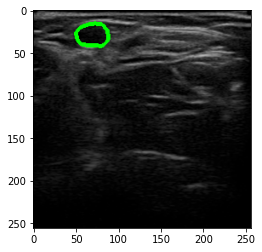

In [28]:
import matplotlib.pyplot as plt
plt.imshow(img_rgb/255)
plt.show()

In [8]:
test_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_test2")
pred_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_pred2")

transform_image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ])
invtransform_label = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize([512,512])
    ])

#eval_dataSet = UltraSoundDataSet_OF(test_dir,transform_image,resize_to=[256,256])
eval_dataSet = UltraSoundDataSet_OF(test_dir,transform_image)
eval_loader = DataLoader(eval_dataSet,batch_size=1,shuffle=False,num_workers=4)

eval_loss = 0
for idx,batch in enumerate(eval_loader):
    im, images_curr, labels_prev_init, labels_curr = batch
    
    #calculate optical flow
    im = im.to(device)
    with torch.no_grad():
        flow = flownet(im)

    flow = np.array(flow.cpu())

    labels_curr_of = np.zeros_like(labels_curr)

    #estimate vessel position by using the flow
    if idx == 0:
        labels_curr_of[0,...] = get_next_mask(labels_prev_init[0,0,...],flow[0,...])
    else:        
        labels_curr_of[0,...] = get_next_mask(labels_prev[0,0,...],flow[0,...])

    labels_curr_of = torch.Tensor(labels_curr_of).to(device,dtype=torch.float32)
    labels_curr = labels_curr.type(torch.float32).to(device)
    images_curr = images_curr.to(device)
    
    with torch.no_grad():
        pred = unet(images_curr,labels_curr_of,mode=int(idx>0))
        #pred = unet(images_curr,labels_curr_of,mode=0)
    
    eval_loss += DiceLoss(pred,labels_curr)
    
    labels_prev = pred.cpu()
    
    pred = invtransform_label(pred.cpu().squeeze(0))
    #fname = "pred%.2f.png"%DiceIndex
    fname = "pred%03d.png" %idx
    sav_path = os.path.join(pred_dir,fname)
    pred.save(sav_path)
    
print('evaluation loss: %.3f' %(eval_loss / len(eval_loader)))

/home/zhenyuli/.local/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


evaluation loss: 0.991


In [10]:
#test_dir = os.path.expanduser("~/workspace/us_robot/DataSet/realDataSet/linear/vessel_dataset")
test_dir = os.path.expanduser("~/workspace/us_robot/DataSet/cepDataset/vessel_dataset")
transform_image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ])

eval_dataSet = UltraSoundDataSet_OF(test_dir,transform_image)
eval_loader = DataLoader(eval_dataSet,batch_size=1,shuffle=False,num_workers=4)


In [16]:
batch = next(iter(eval_loader))
im, images_curr, labels_prev_init, labels_curr = batch

In [13]:
import matplotlib.pyplot as plt

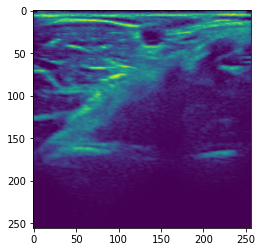

In [17]:
plt.imshow(np.array(images_curr.squeeze()))

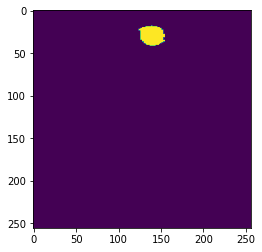

In [18]:
plt.imshow(np.array(labels_curr.squeeze()))